# Customizing Colorbars

In [1]:
import matplotlib.pyplot as plt
plt.style.use('classic')
import numpy as np

As we have seen several times throughout this section, the simplest colorbar can be created with the ``plt.colorbar`` function:

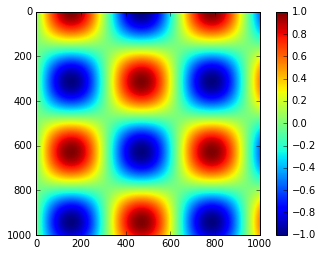

In [2]:
x = np.linspace(0, 10, 1000)
I = np.sin(x) * np.cos(x[:, np.newaxis])

plt.imshow(I)
plt.colorbar();

We'll now discuss a few ideas for customizing these colorbars and using them effectively in various situations.

## Customizing Colorbars

The colormap can be specified using the ``cmap`` argument to the plotting function that is creating the visualization:

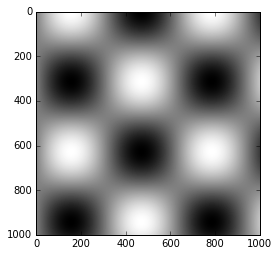

In [3]:
plt.imshow(I, cmap='gray');

All the available colormaps are in the ``plt.cm`` namespace; using Notebook's tab-completion will give you a full list of built-in possibilities:
```
plt.cm.<TAB>
```
But being *able* to choose a colormap is just the first step: more important is how to *decide* among the possibilities!
The choice turns out to be much more subtle than you might initially expect.

### Choosing the Colormap

Broadly, you should be aware of three different categories of colormaps:

- *Sequential colormaps*: These are made up of one continuous sequence of colors (e.g., ``binary`` or ``viridis``).
- *Divergent colormaps*: These usually contain two distinct colors, which show positive and negative deviations from a mean (e.g., ``RdBu`` or ``PuOr``).
- *Qualitative colormaps*: these mix colors with no particular sequence (e.g., ``rainbow`` or ``jet``).

The ``jet`` colormap, which was the default in Matplotlib prior to version 2.0, is an example of a qualitative colormap.
Its status as the default was quite unfortunate, because qualitative maps are often a poor choice for representing quantitative data.
Among the problems is the fact that qualitative maps usually do not display any uniform progression in brightness as the scale increases.

We can see this by converting the ``jet`` colorbar into black and white:

In [4]:
from matplotlib.colors import LinearSegmentedColormap

def grayscale_cmap(cmap):
    """Return a grayscale version of the given colormap"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    
    # convert RGBA to perceived grayscale luminance
    # cf. http://alienryderflex.com/hsp.html
    RGB_weight = [0.299, 0.587, 0.114]
    luminance = np.sqrt(np.dot(colors[:, :3] ** 2, RGB_weight))
    colors[:, :3] = luminance[:, np.newaxis]
        
    return LinearSegmentedColormap.from_list(cmap.name + "_gray", colors, cmap.N)
    

def view_colormap(cmap):
    """Plot a colormap with its grayscale equivalent"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    
    cmap = grayscale_cmap(cmap)
    grayscale = cmap(np.arange(cmap.N))
    
    fig, ax = plt.subplots(2, figsize=(6, 2),
                           subplot_kw=dict(xticks=[], yticks=[]))
    ax[0].imshow([colors], extent=[0, 10, 0, 1])
    ax[1].imshow([grayscale], extent=[0, 10, 0, 1])

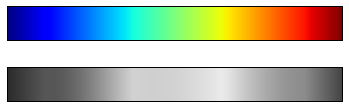

In [5]:
view_colormap('jet')

Notice the bright stripes in the grayscale image.
Even in full color, this uneven brightness means that the eye will be drawn to certain portions of the color range, which will potentially emphasize unimportant parts of the dataset.
It's better to use a colormap such as ``viridis`` (the default as of Matplotlib 2.0), which is specifically constructed to have an even brightness variation across the range.
Thus it not only plays well with our color perception, but also will translate well to grayscale printing:

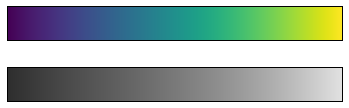

In [6]:
view_colormap('viridis')

If you favor rainbow schemes, another good option for continuous data is the ``cubehelix`` colormap:

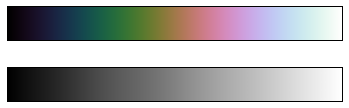

In [7]:
view_colormap('cubehelix')

For other situations, such as showing positive and negative deviations from some mean, dual-color colorbars such as ``RdBu`` (*Red-Blue*) can be useful. However, as you can see in the following figure, it's important to note that the positive-negative information will be lost upon translation to grayscale!

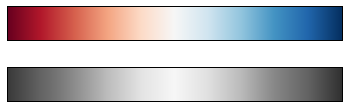

In [8]:
view_colormap('RdBu')

We'll see examples of using some of these color maps as we continue.

### Color limits and extensions

Matplotlib allows for a large range of colorbar customization.
The colorbar itself is simply an instance of ``plt.Axes``, so all of the axes and tick formatting tricks we've learned are applicable.
The colorbar has some interesting flexibility: for example, we can narrow the color limits and indicate the out-of-bounds values with a triangular arrow at the top and bottom by setting the ``extend`` property.
This might come in handy, for example, if displaying an image that is subject to noise:

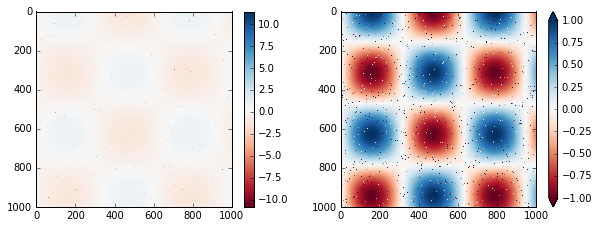

In [9]:
# make noise in 1% of the image pixels
speckles = (np.random.random(I.shape) < 0.01)
I[speckles] = np.random.normal(0, 3, np.count_nonzero(speckles))

plt.figure(figsize=(10, 3.5))

plt.subplot(1, 2, 1)
plt.imshow(I, cmap='RdBu')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(I, cmap='RdBu')
plt.colorbar(extend='both')
plt.clim(-1, 1);

Notice that in the left panel, the default color limits respond to the noisy pixels, and the range of the noise completely washes-out the pattern we are interested in.
In the right panel, we manually set the color limits, and add extensions to indicate values which are above or below those limits.
The result is a much more useful visualization of our data.

### Discrete Color Bars

Colormaps are by default continuous, but sometimes you'd like to represent discrete values.
The easiest way to do this is to use the ``plt.cm.get_cmap()`` function, and pass the name of a suitable colormap along with the number of desired bins:

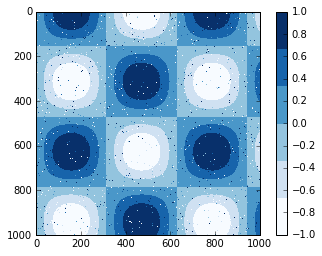

In [10]:
plt.imshow(I, cmap=plt.cm.get_cmap('Blues', 6))
plt.colorbar()
plt.clim(-1, 1);

The discrete version of a colormap can be used just like any other colormap.

## Example: Handwritten Digits

For an example of where this might be useful, let's look at an interesting visualization of some hand written digits data.
This data is included in Scikit-Learn, and consists of nearly 2,000 $8 \times 8$ thumbnails showing various hand-written digits.

For now, let's start by downloading the digits data and visualizing several of the example images with ``plt.imshow()``:

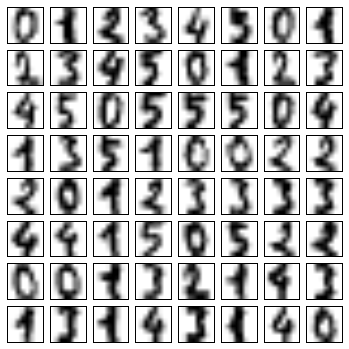

In [11]:
# load images of the digits 0 through 5 and visualize several of them
from sklearn.datasets import load_digits
digits = load_digits(n_class=6)

fig, ax = plt.subplots(8, 8, figsize=(6, 6))
for i, axi in enumerate(ax.flat):
    axi.imshow(digits.images[i], cmap='binary')
    axi.set(xticks=[], yticks=[])

Because each digit is defined by the hue of its 64 pixels, we can consider each digit to be a point lying in 64-dimensional space: each dimension represents the brightness of one pixel.
But visualizing relationships in such high-dimensional spaces can be extremely difficult.
One way to approach this is to use a *dimensionality reduction* technique such as manifold learning to reduce the dimensionality of the data while maintaining the relationships of interest.
Dimensionality reduction is an example of unsupervised machine learning.

In [12]:
# project the digits into 2 dimensions using IsoMap
from sklearn.manifold import Isomap
iso = Isomap(n_components=2)
projection = iso.fit_transform(digits.data)

We'll use our discrete colormap to view the results, setting the ``ticks`` and ``clim`` to improve the aesthetics of the resulting colorbar:

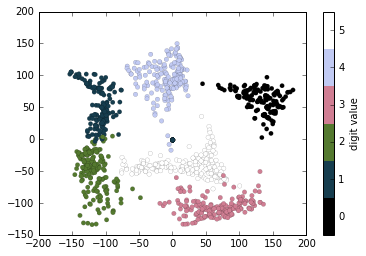

In [13]:
# plot the results
plt.scatter(projection[:, 0], projection[:, 1], lw=0.1,
            c=digits.target, cmap=plt.cm.get_cmap('cubehelix', 6))
plt.colorbar(ticks=range(6), label='digit value')
plt.clim(-0.5, 5.5)

The projection also gives us some interesting insights on the relationships within the dataset: for example, the ranges of 5 and 3 nearly overlap in this projection, indicating that some hand written fives and threes are difficult to distinguish, and therefore more likely to be confused by an automated classification algorithm.
Other values, like 0 and 1, are more distantly separated, and therefore much less likely to be confused.
This observation agrees with our intuition, because 5 and 3 look much more similar than do 0 and 1.